In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4693 - acc: 0.5404
Epoch 00001: val_loss improved from inf to 1.04390, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_9_conv_checkpoint/001-1.0439.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 1.4693 - acc: 0.5404 - val_loss: 1.0439 - val_acc: 0.6648
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5755 - acc: 0.8183
Epoch 00002: val_loss improved from 1.04390 to 0.40446, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_9_conv_checkpoint/002-0.4045.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.5755 - acc: 0.8183 - val_loss: 0.4045 - val_acc: 0.8786
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3826 - acc: 0.8780
Epoch 00003: val_loss did not improve from 0.40446
36805/36

36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9957
Epoch 00055: val_loss did not improve from 0.15663
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0141 - acc: 0.9957 - val_loss: 0.1703 - val_acc: 0.9567
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9977
Epoch 00056: val_loss did not improve from 0.15663
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0082 - acc: 0.9977 - val_loss: 0.1796 - val_acc: 0.9599
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.9987
Epoch 00057: val_loss did not improve from 0.15663
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0051 - acc: 0.9988 - val_loss: 0.1899 - val_acc: 0.9548
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.9983
Epoch 00058: val_loss did not improve from 0.15663
36805/36805 [=====================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9961
Epoch 00085: val_loss did not improve from 0.15663
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0133 - acc: 0.9960 - val_loss: 0.1751 - val_acc: 0.9616
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9979
Epoch 00086: val_loss did not improve from 0.15663
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0080 - acc: 0.9979 - val_loss: 0.1749 - val_acc: 0.9620
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9992
Epoch 00087: val_loss did not improve from 0.15663
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0031 - acc: 0.9992 - val_loss: 0.1866 - val_acc: 0.9592
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9993
Epoch 00088: val_loss did not improve from 0.15663
36805/36805 [========

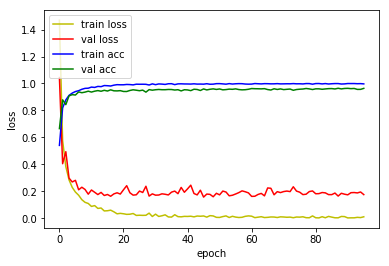

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2128 - acc: 0.9493
Loss: 0.2127867239213095 Accuracy: 0.949325



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_custom_conv_3_VGG_BN_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None

4815/4815 [==============================] - 7s 2ms/sample - loss: 1.2689 - acc: 0.6521
Loss: 1.268929294584201 Accuracy: 0.65212876

1D_CNN_custom_conv_3_VGG_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_123 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_124 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Activation)  (Non

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.6074 - acc: 0.8349
Loss: 0.6074317322589403 Accuracy: 0.83489096

1D_CNN_custom_conv_3_VGG_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_147 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_148 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (Activation)  (No

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2028 - acc: 0.9423
Loss: 0.2028081684592852 Accuracy: 0.9422638

1D_CNN_custom_conv_3_VGG_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (Non

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2128 - acc: 0.9493
Loss: 0.2127867239213095 Accuracy: 0.949325


Instructions for updating:
Colocations handled automatically by placer.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 10.6790 - acc: 0.2589
Epoch 00001: val_loss improved from inf to 11.60893, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_1_conv_checkpoint/001-11.6089.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 10.6797 - acc: 0.2588 - val_loss: 11.6089 - val_acc: 0.2197
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 9.1265 - acc: 0.3773
Epoch 00002: val_loss improved from 11.60893 to 10.65462, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_1_conv_checkpoint/002-10.6546.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 9.1264 - acc: 0.3773 - val_loss: 10.6546 - val_acc: 0.2830
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 8

36800/36805 [============================>.] - ETA: 0s - loss: 3.7107 - acc: 0.7598
Epoch 00026: val_loss did not improve from 9.32690
36805/36805 [==============================] - 83s 2ms/sample - loss: 3.7111 - acc: 0.7598 - val_loss: 10.1618 - val_acc: 0.3389
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6144 - acc: 0.7670
Epoch 00027: val_loss did not improve from 9.32690
36805/36805 [==============================] - 83s 2ms/sample - loss: 3.6152 - acc: 0.7669 - val_loss: 10.7640 - val_acc: 0.3103
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.6188 - acc: 0.7656
Epoch 00028: val_loss did not improve from 9.32690
36805/36805 [==============================] - 83s 2ms/sample - loss: 3.6188 - acc: 0.7656 - val_loss: 10.4060 - val_acc: 0.3333
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.5398 - acc: 0.7721
Epoch 00029: val_loss did not improve from 9.32690
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 2.8479 - acc: 0.8189
Epoch 00055: val_loss did not improve from 9.24055
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.8479 - acc: 0.8189 - val_loss: 9.5369 - val_acc: 0.3836
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8353 - acc: 0.8191
Epoch 00056: val_loss did not improve from 9.24055
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.8358 - acc: 0.8190 - val_loss: 10.2233 - val_acc: 0.3454
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7898 - acc: 0.8228
Epoch 00057: val_loss did not improve from 9.24055
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.7907 - acc: 0.8228 - val_loss: 9.2487 - val_acc: 0.3986
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7991 - acc: 0.8218
Epoch 00058: val_loss did not improve from 9.24055
36805/36805 [=======================

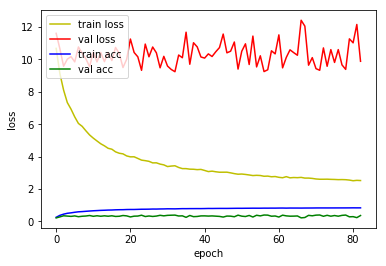

4815/4815 [==============================] - 4s 830us/sample - loss: 9.6762 - acc: 0.3686
Loss: 9.676190913429142 Accuracy: 0.36863968

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.9252 - acc: 0.3487
Epoch 00001: val_loss improved from inf to 3.59976, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_2_conv_checkpoint/001-3.5998.hdf5
36805/36805 [==============================] - 137s 4ms/sample - loss: 3.9253 - acc: 0.3487 - val_loss: 3.5998 - val_acc: 0.2909
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5518 - acc: 0.7114
Epoch 00002: val_loss did not improve from 3.59976
36805/36805 [==============================] - 134s 4ms/sample - loss: 1.5518 - acc: 0.7114 - val_loss: 3.7600 - val_acc: 0.4116
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7629 - acc: 0.8651
Epoch 00003: val_loss did not improve from 3.59976
36805/36805 [=======

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2595 - acc: 0.9721
Epoch 00030: val_loss did not improve from 3.59976
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.2595 - acc: 0.9722 - val_loss: 6.7688 - val_acc: 0.4309
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2078 - acc: 0.9790
Epoch 00031: val_loss did not improve from 3.59976
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.2080 - acc: 0.9790 - val_loss: 6.7510 - val_acc: 0.4274
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2314 - acc: 0.9768
Epoch 00032: val_loss did not improve from 3.59976
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.2318 - acc: 0.9768 - val_loss: 7.0581 - val_acc: 0.4195
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2392 - acc: 0.9745
Epoch 00033: val_loss did not improve from 3.59976
36805/36805 [========

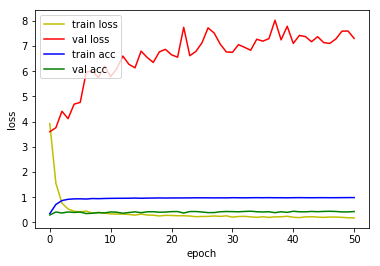

4815/4815 [==============================] - 6s 1ms/sample - loss: 3.7823 - acc: 0.2573
Loss: 3.7823052178043195 Accuracy: 0.25732088

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2307 - acc: 0.4379
Epoch 00001: val_loss improved from inf to 1.92702, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_3_conv_checkpoint/001-1.9270.hdf5
36805/36805 [==============================] - 157s 4ms/sample - loss: 2.2305 - acc: 0.4379 - val_loss: 1.9270 - val_acc: 0.4503
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8173 - acc: 0.7748
Epoch 00002: val_loss improved from 1.92702 to 1.84604, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_3_conv_checkpoint/002-1.8460.hdf5
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.8174 - acc: 0.7748 - val_loss: 1.8460 - val_acc: 0.5465
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0526 - acc: 0.9920
Epoch 00029: val_loss did not improve from 1.84604
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0526 - acc: 0.9920 - val_loss: 3.4117 - val_acc: 0.5597
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9936
Epoch 00030: val_loss did not improve from 1.84604
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0460 - acc: 0.9936 - val_loss: 3.2476 - val_acc: 0.5593
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.9923
Epoch 00031: val_loss did not improve from 1.84604
36805/36805 [==============================] - 151s 4ms/sample - loss: 0.0508 - acc: 0.9923 - val_loss: 3.6732 - val_acc: 0.5232
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0751 - acc: 0.9872
Epoch 00032: val_loss did not improve from 1.84604
36805/36805 [=====================

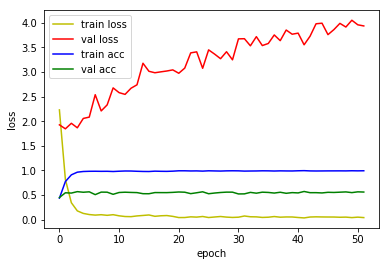

4815/4815 [==============================] - 7s 1ms/sample - loss: 1.9808 - acc: 0.5047
Loss: 1.9808175353617683 Accuracy: 0.5046729

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9201 - acc: 0.4499
Epoch 00001: val_loss improved from inf to 1.70522, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_4_conv_checkpoint/001-1.7052.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 1.9203 - acc: 0.4499 - val_loss: 1.7052 - val_acc: 0.4815
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1052 - acc: 0.6702
Epoch 00002: val_loss improved from 1.70522 to 1.37478, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_4_conv_checkpoint/002-1.3748.hdf5
36805/36805 [==============================] - 158s 4ms/sample - loss: 1.1053 - acc: 0.6702 - val_loss: 1.3748 - val_acc: 0.6161
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9922
Epoch 00029: val_loss did not improve from 1.19192
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0364 - acc: 0.9921 - val_loss: 1.8698 - val_acc: 0.6564
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9889
Epoch 00030: val_loss did not improve from 1.19192
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0466 - acc: 0.9888 - val_loss: 1.7705 - val_acc: 0.6713
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9942
Epoch 00031: val_loss did not improve from 1.19192
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0316 - acc: 0.9941 - val_loss: 1.7353 - val_acc: 0.6846
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9951
Epoch 00032: val_loss did not improve from 1.19192
36805/36805 [========

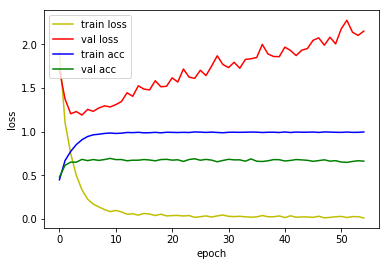

4815/4815 [==============================] - 7s 1ms/sample - loss: 1.3364 - acc: 0.6432
Loss: 1.3364254650916143 Accuracy: 0.6431983

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8111 - acc: 0.4643
Epoch 00001: val_loss improved from inf to 1.49466, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_5_conv_checkpoint/001-1.4947.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 1.8111 - acc: 0.4642 - val_loss: 1.4947 - val_acc: 0.5320
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1281 - acc: 0.6648
Epoch 00002: val_loss improved from 1.49466 to 1.15129, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_5_conv_checkpoint/002-1.1513.hdf5
36805/36805 [==============================] - 163s 4ms/sample - loss: 1.1283 - acc: 0.6648 - val_loss: 1.1513 - val_acc: 0.6811
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9950
Epoch 00028: val_loss did not improve from 0.95411
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0306 - acc: 0.9950 - val_loss: 1.2963 - val_acc: 0.7284
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9911
Epoch 00029: val_loss did not improve from 0.95411
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0433 - acc: 0.9911 - val_loss: 1.4451 - val_acc: 0.7177
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9906
Epoch 00030: val_loss did not improve from 0.95411
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0439 - acc: 0.9906 - val_loss: 1.2909 - val_acc: 0.7340
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9915
Epoch 00031: val_loss did not improve from 0.95411
36805/36805 [=====================


1D_CNN_custom_conv_3_VGG_BN_5_conv Model


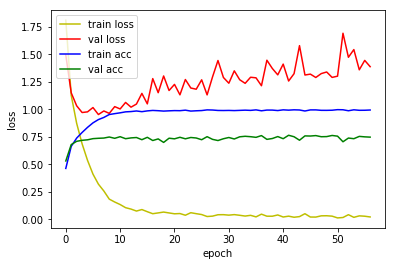

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.0303 - acc: 0.7092
Loss: 1.030256156634195 Accuracy: 0.7092419

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8616 - acc: 0.4354
Epoch 00001: val_loss improved from inf to 1.53369, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_6_conv_checkpoint/001-1.5337.hdf5
36805/36805 [==============================] - 189s 5ms/sample - loss: 1.8615 - acc: 0.4354 - val_loss: 1.5337 - val_acc: 0.5164
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1312 - acc: 0.6581
Epoch 00002: val_loss improved from 1.53369 to 1.05902, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_6_conv_checkpoint/002-1.0590.hdf5
36805/36805 [==============================] - 166s 5ms/sample - loss: 1.1313 - acc: 0.6580 - val_loss: 1.0590 - val_acc: 0.6876
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9825
Epoch 00027: val_loss did not improve from 0.52928
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0709 - acc: 0.9824 - val_loss: 0.7253 - val_acc: 0.8309
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0602 - acc: 0.9866
Epoch 00028: val_loss did not improve from 0.52928
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0602 - acc: 0.9866 - val_loss: 0.5529 - val_acc: 0.8689
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9925
Epoch 00029: val_loss did not improve from 0.52928
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0414 - acc: 0.9925 - val_loss: 0.6033 - val_acc: 0.8539
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0646 - acc: 0.9836
Epoch 00030: val_loss did not improve from 0.52928
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9903
Epoch 00057: val_loss did not improve from 0.52928
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0402 - acc: 0.9902 - val_loss: 0.6165 - val_acc: 0.8756
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9954
Epoch 00058: val_loss did not improve from 0.52928
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0229 - acc: 0.9954 - val_loss: 0.5976 - val_acc: 0.8791
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9981
Epoch 00059: val_loss did not improve from 0.52928
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0138 - acc: 0.9981 - val_loss: 0.6198 - val_acc: 0.8786
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0161 - acc: 0.9973
Epoch 00060: val_loss did not improve from 0.52928
36805/36805 [========

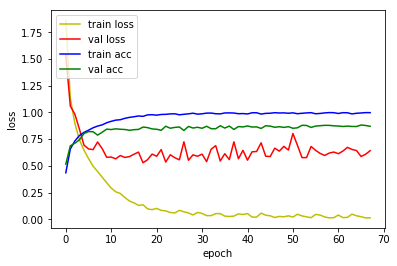

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.6444 - acc: 0.8258
Loss: 0.6444138161366108 Accuracy: 0.82575285

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9638 - acc: 0.3945
Epoch 00001: val_loss improved from inf to 1.67748, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_7_conv_checkpoint/001-1.6775.hdf5
36805/36805 [==============================] - 203s 6ms/sample - loss: 1.9638 - acc: 0.3945 - val_loss: 1.6775 - val_acc: 0.4675
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1099 - acc: 0.6658
Epoch 00002: val_loss improved from 1.67748 to 0.93467, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_7_conv_checkpoint/002-0.9347.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 1.1099 - acc: 0.6658 - val_loss: 0.9347 - val_acc: 0.7312
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9875
Epoch 00026: val_loss did not improve from 0.25158
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0510 - acc: 0.9874 - val_loss: 0.3195 - val_acc: 0.9152
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0537 - acc: 0.9862
Epoch 00027: val_loss did not improve from 0.25158
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0538 - acc: 0.9862 - val_loss: 0.3126 - val_acc: 0.9203
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0605 - acc: 0.9836
Epoch 00028: val_loss did not improve from 0.25158
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0605 - acc: 0.9836 - val_loss: 0.3472 - val_acc: 0.9119
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9927
Epoch 00029: val_loss did not improve from 0.25158
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9946
Epoch 00056: val_loss did not improve from 0.25158
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0208 - acc: 0.9946 - val_loss: 0.4164 - val_acc: 0.9108
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9959
Epoch 00057: val_loss did not improve from 0.25158
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0172 - acc: 0.9959 - val_loss: 0.3576 - val_acc: 0.9236
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9934
Epoch 00058: val_loss did not improve from 0.25158
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0251 - acc: 0.9934 - val_loss: 0.2596 - val_acc: 0.9362
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9964
Epoch 00059: val_loss did not improve from 0.25158
36805/36805 [========

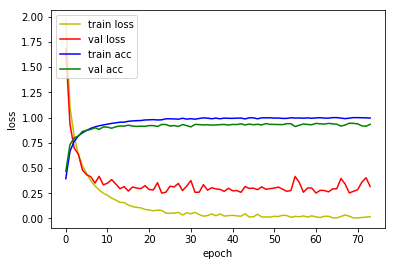

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.3201 - acc: 0.9128
Loss: 0.32009967512307014 Accuracy: 0.9127726

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9040 - acc: 0.4209
Epoch 00001: val_loss improved from inf to 1.59480, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_8_conv_checkpoint/001-1.5948.hdf5
36805/36805 [==============================] - 216s 6ms/sample - loss: 1.9039 - acc: 0.4209 - val_loss: 1.5948 - val_acc: 0.4910
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8922 - acc: 0.7382
Epoch 00002: val_loss improved from 1.59480 to 0.66022, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_8_conv_checkpoint/002-0.6602.hdf5
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.8924 - acc: 0.7381 - val_loss: 0.6602 - val_acc: 0.8132
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9887
Epoch 00024: val_loss did not improve from 0.15969
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0417 - acc: 0.9887 - val_loss: 0.2077 - val_acc: 0.9450
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9871
Epoch 00025: val_loss did not improve from 0.15969
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0471 - acc: 0.9871 - val_loss: 0.2232 - val_acc: 0.9404
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9920
Epoch 00026: val_loss did not improve from 0.15969
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0342 - acc: 0.9920 - val_loss: 0.2237 - val_acc: 0.9415
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9932
Epoch 00027: val_loss did not improve from 0.15969
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9970
Epoch 00053: val_loss did not improve from 0.14979
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0113 - acc: 0.9970 - val_loss: 0.1854 - val_acc: 0.9543
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9969
Epoch 00054: val_loss did not improve from 0.14979
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0126 - acc: 0.9969 - val_loss: 0.1914 - val_acc: 0.9555
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9976
Epoch 00055: val_loss did not improve from 0.14979
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0106 - acc: 0.9976 - val_loss: 0.1770 - val_acc: 0.9574
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9961
Epoch 00056: val_loss did not improve from 0.14979
36805/36805 [=====================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9980
Epoch 00083: val_loss did not improve from 0.14979
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0084 - acc: 0.9980 - val_loss: 0.1812 - val_acc: 0.9562
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9996
Epoch 00084: val_loss did not improve from 0.14979
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0028 - acc: 0.9996 - val_loss: 0.1566 - val_acc: 0.9632
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9995
Epoch 00085: val_loss did not improve from 0.14979
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0029 - acc: 0.9995 - val_loss: 0.1746 - val_acc: 0.9604
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9979
Epoch 00086: val_loss did not improve from 0.14979
36805/36805 [========

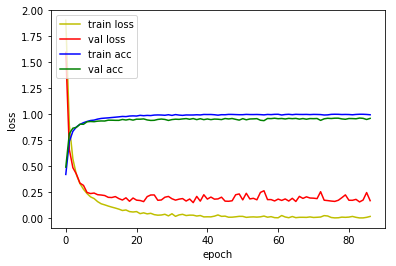

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2005 - acc: 0.9435
Loss: 0.20054632041289985 Accuracy: 0.9435099

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4880 - acc: 0.5399
Epoch 00001: val_loss improved from inf to 1.08879, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_9_conv_checkpoint/001-1.0888.hdf5
36805/36805 [==============================] - 228s 6ms/sample - loss: 1.4879 - acc: 0.5398 - val_loss: 1.0888 - val_acc: 0.6457
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5916 - acc: 0.8145
Epoch 00002: val_loss improved from 1.08879 to 0.47684, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_BN_9_conv_checkpoint/002-0.4768.hdf5
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.5916 - acc: 0.8144 - val_loss: 0.4768 - val_acc: 0.8460
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0172 - acc: 0.9958
Epoch 00026: val_loss did not improve from 0.17174
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0172 - acc: 0.9958 - val_loss: 0.1928 - val_acc: 0.9488
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9926
Epoch 00027: val_loss did not improve from 0.17174
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0268 - acc: 0.9926 - val_loss: 0.1942 - val_acc: 0.9518
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9936
Epoch 00028: val_loss did not improve from 0.17174
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0222 - acc: 0.9936 - val_loss: 0.2223 - val_acc: 0.9448
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9942
Epoch 00029: val_loss did not improve from 0.17174
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9982
Epoch 00055: val_loss did not improve from 0.16631
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0070 - acc: 0.9982 - val_loss: 0.2150 - val_acc: 0.9522
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0116 - acc: 0.9967
Epoch 00056: val_loss did not improve from 0.16631
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0116 - acc: 0.9967 - val_loss: 0.2586 - val_acc: 0.9446
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9977
Epoch 00057: val_loss did not improve from 0.16631
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0096 - acc: 0.9976 - val_loss: 0.1847 - val_acc: 0.9539
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9971
Epoch 00058: val_loss did not improve from 0.16631
36805/36805 [=====================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9968
Epoch 00084: val_loss did not improve from 0.15827
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0109 - acc: 0.9968 - val_loss: 0.2403 - val_acc: 0.9511
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9987
Epoch 00085: val_loss did not improve from 0.15827
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0047 - acc: 0.9987 - val_loss: 0.2048 - val_acc: 0.9550
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9974
Epoch 00086: val_loss did not improve from 0.15827
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0090 - acc: 0.9974 - val_loss: 0.1820 - val_acc: 0.9590
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9962
Epoch 00087: val_loss did not improve from 0.15827
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.9995
Epoch 00113: val_loss did not improve from 0.15150
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0024 - acc: 0.9995 - val_loss: 0.1700 - val_acc: 0.9681
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9983
Epoch 00114: val_loss did not improve from 0.15150
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0062 - acc: 0.9983 - val_loss: 0.1650 - val_acc: 0.9681
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9992
Epoch 00115: val_loss did not improve from 0.15150
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0029 - acc: 0.9992 - val_loss: 0.1919 - val_acc: 0.9616
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.9988
Epoch 00116: val_loss did not improve from 0.15150
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9953
Epoch 00142: val_loss did not improve from 0.14535
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0168 - acc: 0.9953 - val_loss: 0.1653 - val_acc: 0.9669
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9977
Epoch 00143: val_loss did not improve from 0.14535
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0074 - acc: 0.9977 - val_loss: 0.1717 - val_acc: 0.9667
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.9998
Epoch 00144: val_loss did not improve from 0.14535
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1568 - val_acc: 0.9676
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.2969e-04 - acc: 1.0000
Epoch 00145: val_loss did not improve from 0.14535
36805/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9990
Epoch 00171: val_loss did not improve from 0.13777
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0035 - acc: 0.9989 - val_loss: 0.1671 - val_acc: 0.9665
Epoch 172/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9970
Epoch 00172: val_loss did not improve from 0.13777
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0105 - acc: 0.9970 - val_loss: 0.1667 - val_acc: 0.9669
Epoch 173/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9977
Epoch 00173: val_loss did not improve from 0.13777
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0090 - acc: 0.9976 - val_loss: 0.1540 - val_acc: 0.9672
Epoch 174/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9986
Epoch 00174: val_loss did not improve from 0.13777
36805/36805 [==================

Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9983
Epoch 00201: val_loss did not improve from 0.13777
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0062 - acc: 0.9983 - val_loss: 0.1673 - val_acc: 0.9697
Epoch 202/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.9998
Epoch 00202: val_loss did not improve from 0.13777
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1711 - val_acc: 0.9660
Epoch 203/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0058 - acc: 0.9984
Epoch 00203: val_loss did not improve from 0.13777
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0058 - acc: 0.9984 - val_loss: 0.1576 - val_acc: 0.9690
Epoch 204/500
36800/36805 [============================>.] - ETA: 0s - loss: 9.4246e-04 - acc: 0.9998
Epoch 00204: val_loss did not improve from 0.13777
36805/36805 [

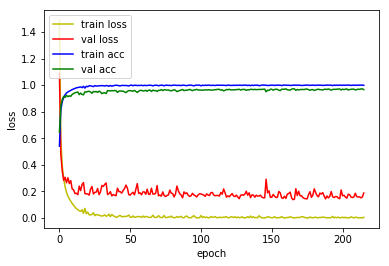

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1917 - acc: 0.9632
Loss: 0.1916768369667942 Accuracy: 0.96323985



In [9]:
base = '1D_CNN_custom_conv_3_VGG_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [10]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.3364 - acc: 0.6432
Loss: 1.3364254650916143 Accuracy: 0.6431983

1D_CNN_custom_conv_3_VGG_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (Non

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.6444 - acc: 0.8258
Loss: 0.6444138161366108 Accuracy: 0.82575285

1D_CNN_custom_conv_3_VGG_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (No

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2005 - acc: 0.9435
Loss: 0.20054632041289985 Accuracy: 0.9435099

1D_CNN_custom_conv_3_VGG_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (N

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.1917 - acc: 0.9632
Loss: 0.1916768369667942 Accuracy: 0.96323985


In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None

4815/4815 [==============================] - 10s 2ms/sample - loss: 2.3627 - acc: 0.6409
Loss: 2.3627194363999093 Accuracy: 0.6409138

1D_CNN_custom_conv_3_VGG_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (No

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.7468 - acc: 0.8476
Loss: 0.746812808423894 Accuracy: 0.8475597

1D_CNN_custom_conv_3_VGG_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (Non

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2275 - acc: 0.9477
Loss: 0.22748439204796903 Accuracy: 0.94766355

1D_CNN_custom_conv_3_VGG_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.2402 - acc: 0.9545
Loss: 0.2402077064204377 Accuracy: 0.9545171
